In [1]:
import numpy as np
import torch

# Loading maps

In [2]:
import mapping.utils as maps
import matplotlib.pyplot as plt

In [3]:
FILE = './data/file150.json' # Sample file

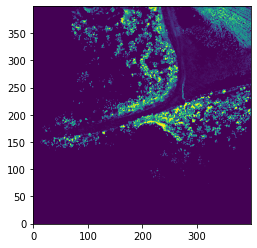

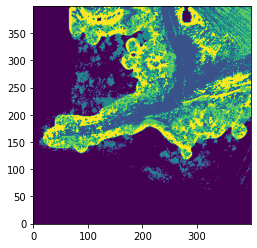

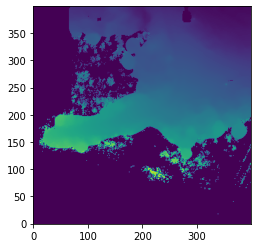

In [4]:
object_map, observed_map, terrain_map, origin_x, origin_y, resolution, num_x, num_y = maps.load_layers(FILE)

plt.imshow(object_map, origin ='lower')
plt.show()

plt.imshow(observed_map, origin ='lower')
plt.show()

plt.imshow(terrain_map, origin ='lower')
plt.show()

## Finding a path with a Rapidly-exploring Random Tree (RRT)

In [5]:
#import sys
#from pathlib import Path

#PATH_TO_SHARED_LIB = str(Path("").resolve()) + "/rrt_sharp/src/rrt_sharp/build/"
#sys.path.append(PATH_TO_SHARED_LIB)

#from rrt_sharp_py import *

In [6]:
# Configure RRTSharp object

# Create Map dimension
#rrt_sharp = RRTSharp([2, 3, 4])

# rrt_sharp.set_map_info(origin_x, origin_y, resolution, num_x, num_y)
# rrt_sharp.set_object_map(object_map.flatten().tolist())
# rrt_sharp.set_observed_map(observed_map.astype(int).flatten().tolist())
# rrt_sharp.set_terrain_map(terrain_map.flatten().tolist())
# rrt_sharp.set_start_state(227.0, -143.0, 180.0)
# rrt_sharp.set_goal_state(114.0, -250.0, 300.0)
# rrt_sharp.set_stop_radius(5.0)

In [7]:
# Run RRT

# rrt_sharp.init()
# rrt_sharp.run()

# Simulating dynamics

In [8]:
import optimization.bicycle_model as bicycle_model
from optimization.utils import *
import optimization.quadratic as qr

## Simple example

In [9]:
model = bicycle_model.BicycleModelParameters(dt=0.02, max_steering_angle=2, min_steering_angle=-2, wheelbase=1)

# state: x, y, yaw, velocity

nx = 4
x0 = torch.tensor([0, 0, 0, 0.2]) # initial state

# controls: acceleration, steering_angle

nu = 2
U = torch.tensor([[2, 0], [1.2, 0.3], [1.4, 0.4], [0, 0.2]])

N = U.size(0)+1

# Simulate dynamics

params = OptimizationParameters(nx=nx, nu=nu, N=N, model=model)

# Caution: no constraints on the controls are handled by the forward pass/dynamics
X = simulate(x0, U, bicycle_model.discrete_dynamics, params)

print(X)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-01],
        [4.4000e-03, 0.0000e+00, 0.0000e+00, 2.4000e-01],
        [9.4400e-03, 3.7417e-06, 1.5591e-03, 2.6400e-01],
        [1.5000e-02, 1.8616e-05, 3.9098e-03, 2.9200e-01],
        [2.0840e-02, 4.4906e-05, 5.0936e-03, 2.9200e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])


## Using iLQR to follow reference trajectory

In [10]:
# problem size 
dt = model.dt 
tf = 5
t_vec = np.arange(0, tf, dt)

# create reference trajectory 
Xref, Uref = torch.zeros((N, nx)), torch.zeros((N-1, nu)) # TODO: generate non trivial reference trajectory

# tracking cost function
Q = torch.eye(nx)
R = torch.eye(nu)
Qf = 10*Q

# the params needed by iLQR 
qrParams = qr.QR(
    Q=Q,
    Qf=Qf,
    R=R,
    Xref=Xref,
    Uref=Uref,
    nx=params.nx,
    nu=params.nu,
    N=Xref.size(0),
    model=params.model
)

# initial condition 
x0 = Xref[0]

# initial guess controls 
U = Uref + .0001*torch.rand(Uref.size())

# solve with iLQR
#X, U, K = qr.iLQR(x0, U, bicycle_model.discrete_dynamics, qrParams)

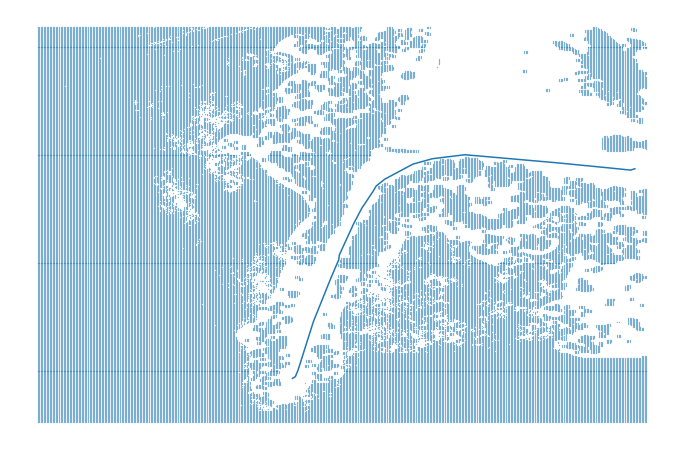

In [11]:
#traj_x = np.array(list(rrt_sharp.get_trajectory_x()))
#traj_y = np.array(list(rrt_sharp.get_trajectory_y()))

#search_space_x = list(rrt_sharp.get_search_space_x())
#search_space_y = list(rrt_sharp.get_search_space_y())

traj_x = np.load('traj_x.npy')
traj_y = np.load('traj_y.npy')

search_space_x = np.load('search_space_x.npy')
search_space_y = np.load('search_space_y.npy')

points = np.dstack((traj_x, traj_y)).squeeze()
distances = np.linalg.norm(points[1:] - points[:-1], axis=1)
min_dist = distances.min()

traj_x, traj_y, N = linspace(traj_x, traj_y, min_dist)

Xref, Uref = np.array([traj_x, traj_y, np.zeros(N), 4.5*np.ones(N)]).T, np.zeros((N-1, nu))

fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(traj_x, traj_y)

plt.axis('off')
#plt.savefig("assets/rrt-150.png", bbox_inches='tight')
plt.show()

In [12]:
# N = max(traj_x.shape[0], traj_x.shape[0] * (250//traj_x.shape[0]))

# # Upsample trajectories if necessary
# if N > traj_x.shape[0]:
#     upsampling_factor = 250//traj_x.shape[0]
    
#     # Forming points
#     points = np.dstack((traj_x, traj_y)).squeeze()
    
#     # Forming groups of consecutive points
#     n_groups = len(traj_x) - 1
#     indices = np.arange(n_groups)[:, None] + np.array([0, 1])
#     groups = points[indices]
    
#     # We upsample by doing linear interpolation between points
#     new_groups = np.linspace(groups[:, 0], groups[:, 1], 1+upsampling_factor, axis=1)
    
#     # We merge the new points
#     new_groups = new_groups[:, :-1, :] # skipping last point of each group to avoid duplicates
#     new_points = np.vstack((new_groups.reshape((-1, 2)), points[None, -1, :])) # don't forget very last point
    
#     traj_x = new_points[:, 0]
#     traj_y = new_points[:, 1]
    
#     N = traj_x.shape[0]
    
# # create reference trajectory 
# Xref, Uref = np.array([traj_x, traj_y, np.zeros(N), 30*np.ones(N)]).T, np.zeros((N-1, nu))

## MPPI

In [13]:
from pytorch_mppi import MPPI
import gymnasium as gym
from gymnasium import spaces
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cpu


/home/eyoun1/anaconda3/envs/ocrl/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [99]:
x0 = torch.Tensor(Xref[0])
xg = torch.Tensor(Xref[-1])
cost_map = torch.Tensor(object_map)

#u_min = torch.Tensor([-5, -1])
#u_max = torch.Tensor([5,3])
                   
Q = torch.diag(torch.Tensor([5, 5, 1, 1])).to(device)
R = torch.diag(torch.Tensor([5, 1])).to(device)
Qf = 20*Q
model = bicycle_model.BicycleModelParameters(dt=0.2, max_steering_angle=1, min_steering_angle=-1, wheelbase=7)
params = OptimizationParameters(nx=nx, nu=nu, N=N, model=model)

def cost_fn(x,u):
    if i < N-1:
        xref = torch.Tensor(Xref[i]).to(device)
        uref = torch.Tensor(Uref[i]).to(device)
        x, u = x.to(device), u.to(device)
        if len(x.shape) > 1:
            x_diff = x - xref
            u_diff = u - uref
            cost = 0.5*torch.sum((x_diff @ Q * x_diff), dim=1) + 0.5*torch.sum((u_diff @ R * u_diff), dim=1)
        else:
            x_diff = x - xref
            u_diff = u - uref
            #cost = cost_map[loc[0], loc[1]] + torch.norm(xg-loc)
            #cost = (cost_map[loc[0], loc[1]] * 100) + torch.norm(xg-loc,p=2)
            cost = 0.5*(x_diff @ Q @ x_diff) + 0.5*(u_diff @ R @ u_diff)
    else:
        xref = torch.Tensor(Xref[i]).to(device)
        x = x.to(device)
        if len(x.shape) > 1:
            x_diff = x - xref
            cost = torch.sum((x_diff @ Qf * x_diff), dim = 1)
        else:
            x_diff = x - xref
            #cost = cost_map[loc[0], loc[1]] + torch.norm(xg-loc)
            #cost = (cost_map[loc[0], loc[1]] * 100) + torch.norm(xg-loc,p=2)
            cost = (x_diff @ Qf * x_diff.T) 
    return cost.to(device)

def dynamics_fn(x, u):
    return bicycle_model.discrete_dynamics(x,u,params)

class BikeEnv(gym.Env):
  #metadata = {'render.modes': ['human']}

    def __init__(self, nu, dynamics, params, cost_fn, cost_map, x0, xg):
        super(BikeEnv, self).__init__()
        max_dim = 400
        self.x0 = x0
        self.params = params
        self.state = x0
        self.xg = xg
        self.cost_map = cost_map
        self.dynamics = dynamics
        self.cost_fn = cost_fn
        self.mean = torch.zeros(2)
        self.action_space = spaces.Discrete(nu)
        self.observation_space = spaces.Box(low=0, high=max_dim, shape=cost_map.shape, dtype=np.uint8)

    def step(self, action):
        self.state = self.dynamics(self.state, action)
        observation = self.state
        reward = self.cost_fn(self.state, action)
        return observation, reward, _, _

    def reset(self):
        self.state = self.x0
        return self.state # reward, done, info can't be included
  #def render(self, mode='human'):
  #  ...
  #def close (self):
  #|  ...

In [201]:
env = BikeEnv(nu, dynamics_fn, params, cost_fn, torch.Tensor(object_map), x0, xg)
controller = MPPI(env.dynamics, env.cost_fn, 4, torch.eye(2), horizon = 5,device = device, num_samples=50000)

In [202]:
obs = env.reset()
iterations = N
path = torch.zeros([iterations, 4])
controls = torch.zeros([iterations, 2])
for i in range(iterations):
    action = controller.command(obs)
    obs, reward, _, _ = env.step(action)
    path[i] = obs
    controls[i] = action

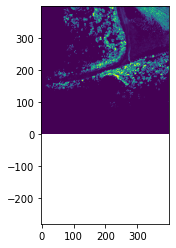

In [203]:
x = path[:,0]
y = path[:,1]

plt.imshow(object_map, origin ='lower')
plt.plot(x,y, color='w')
plt.show()

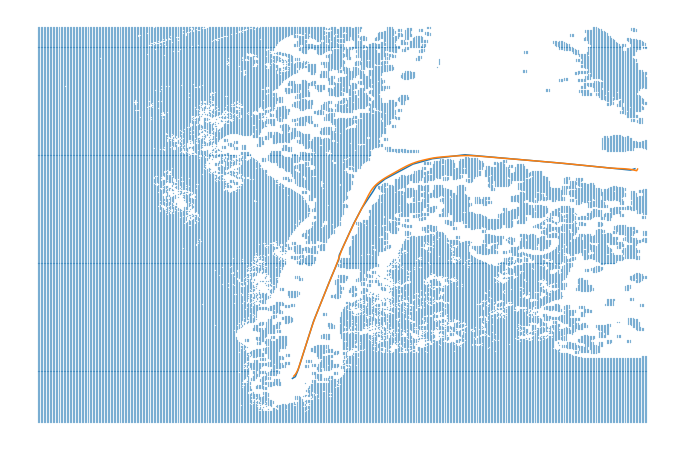

In [204]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.scatter(search_space_x, search_space_y, s=0.05)

plt.plot(traj_x, traj_y)

plt.plot(x, y)

plt.axis('off')
#plt.savefig("assets/rrt-150.png", bbox_inches='tight')
plt.show()

Text(0, 0.5, 'Acceleration [m/(s^2)]')

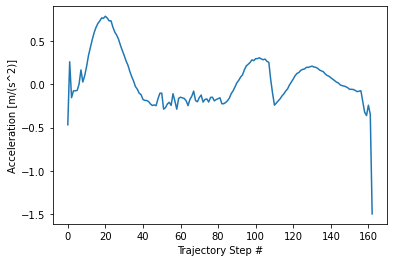

In [216]:
plt.plot(controls[:, 0])
plt.xlabel('Trajectory Step #')
plt.ylabel('Acceleration [m/(s^2)]')

Text(0, 0.5, 'Steering Angle [rads]')

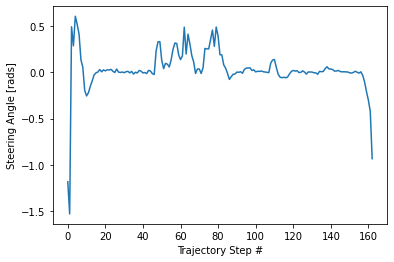

In [217]:
plt.plot(controls[:, 1])
plt.xlabel('Trajectory Step #')
plt.ylabel('Steering Angle [rads]')